### Libraries and imports

In [ ]:
from __future__ import annotations
import seisbench.data as sbd
import seisbench.generate as sbg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from seisbench.generate import RandomWindow
from dataclasses import dataclass
from typing import Any, Dict, Tuple, Optional

import numpy as np
import torch
from seisbench.generate import RandomWindow
from seisbench.data import WaveformDataset
import matplotlib.pyplot as plt
import numpy as np




### Loading dataset

In [2]:
from seisbench.data import WaveformDataset

path = r"C:\Users\barte\OneDrive\Pulpit\FO - projekt\FO--ml-seismic-classifier\iquique"
iquique_dataset = WaveformDataset(path)
noise_dataset = sbd.InstanceNoise()

2026-01-11 14:41:38,114 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2026-01-11 14:41:40,544 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2026-01-11 14:41:40,547 | seisbench | WARNING | Default output component order 'ZNE' does not match dataset component order 'ENZ'. Please make sure this is intended.


# 1. Iquique metadata analysis

In [3]:
iquique_metadata = iquique_dataset.metadata
iquique_metadata.head()

,index,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,path_back_azimuth_deg,station_network_code,station_code,trace_channel,station_location_code,...,trace_sampling_rate_hz,trace_completeness,trace_has_spikes,trace_start_time,trace_P_arrival_sample,trace_S_arrival_sample,trace_name_original,trace_chunk,trace_component_order,split
0,0,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,161.009411,7K,BOLO,EH*,NaN,...,100.0,1.0,False,2014-05-01T00:52:20.630000Z,2000.0,3564.0,7K.BOLO.,,ZNE,train
1,1,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,311.334575,CX,PB08,HH*,NaN,...,100.0,1.0,False,2014-05-01T00:52:19.048393Z,2000.0,NaN,CX.PB08.,,ZNE,test
2,2,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,329.936310,DG,IN17,HH*,NaN,...,100.0,1.0,False,2014-05-01T00:52:20.740000Z,2000.0,3551.0,DG.IN17.,,ZNE,dev
3,3,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,327.358785,DG,IN06,HH*,NaN,...,100.0,1.0,False,2014-05-01T00:52:09.279762Z,2000.0,2697.0,DG.IN06.,,ZNE,train
4,4,2014-05-01T00:52:20.970000Z,-19.4527,-69.9762,57.95,211.759639,DG,IN10,HH*,NaN,...,100.0,1.0,False,2014-05-01T00:52:09.700000Z,2000.0,2761.0,DG.IN10.,,ZNE,dev


In [5]:
columns = iquique_metadata.columns.tolist()
for column in columns:
    print(column, ":", iquique_metadata[column].iloc[0])

index : 0
source_origin_time : 2014-05-01T00:52:20.970000Z
source_latitude_deg : -19.4527
source_longitude_deg : -69.9762
source_depth_km : 57.95
path_back_azimuth_deg : 161.009411211
station_network_code : 7K
station_code : BOLO
trace_channel : EH*
station_location_code : nan
station_latitude_deg : -18.34
station_longitude_deg : -70.38
station_elevation_m : 1.0
trace_name : bucket0$0,:3,:15564
trace_sampling_rate_hz : 100.0
trace_completeness : 1.0
trace_has_spikes : False
trace_start_time : 2014-05-01T00:52:20.630000Z
trace_P_arrival_sample : 2000.0
trace_S_arrival_sample : 3564.0
trace_name_original : 7K.BOLO.
trace_chunk : 
trace_component_order : ZNE
split : train


- index: row index in the dataframe.

- source_origin_time: event origin time (start time of the earthquake).

- source_latitude_deg / source_longitude_deg: event location coordinates (degrees).

- source_depth_km: hypocenter depth (km).

- path_back_azimuth_deg: back-azimuth from station to source (degrees).

- station_network_code: seismic network code (e.g., 7K).

- station_code: station code within the network (e.g., BOLO).

- station_location_code: location code (often 2 characters, e.g., 00); NaN = missing/unknown.

- station_latitude_deg / station_longitude_deg: station coordinates (degrees).

- station_elevation_m: station elevation above sea level (m).

- trace_channel: channel/band code pattern (e.g., EH* = EH channel for any component).

- trace_component_order: component order in the stored data (e.g., ZNE = vertical, north, east).

- trace_sampling_rate_hz: sampling rate (Hz).

- trace_start_time: start time of the waveform window.

- trace_P_arrival_sample: sample index of the P-wave arrival.

- trace_S_arrival_sample: sample index of the S-wave arrival.

- trace_completeness: fraction of valid samples (0–1); 1.0 = no gaps/padding.

- trace_has_spikes: quality flag indicating whether spikes/artifacts were detected.

- trace_name: internal pointer/key to the waveform data in the HDF5 file.

- trace_name_original: original trace identifier before conversion (e.g., NET.STA.LOC...).

- trace_chunk: chunk/partition identifier (empty = no chunking / default).

- split: dataset split label (train, dev, test).

#### Waveforms associated with trace

waveforms.shape: (3, 15564)


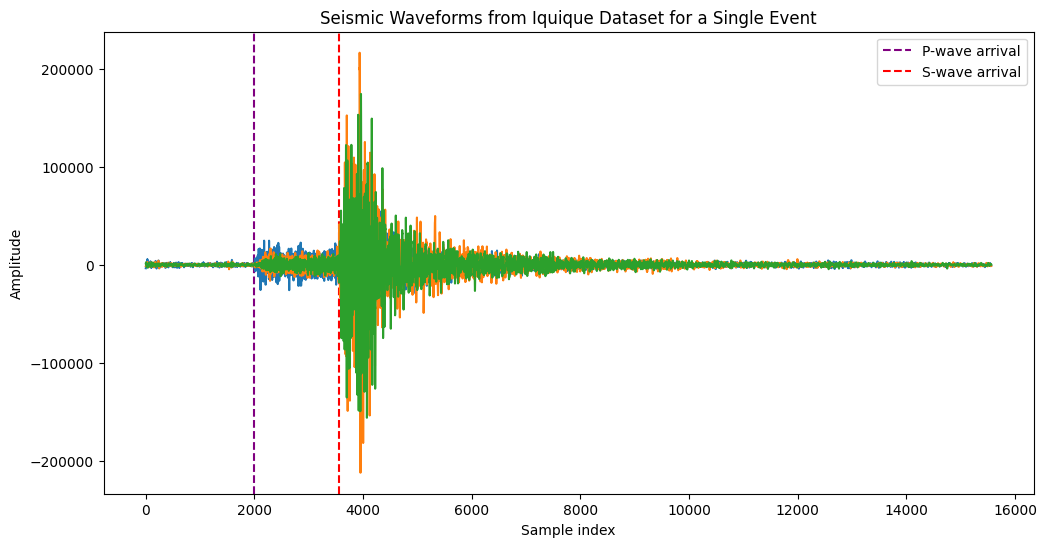

In [43]:
waveforms = iquique_dataset.get_waveforms(0)
print("waveforms.shape:", waveforms.shape)

plt.figure(figsize=(12, 6))
plt.title("Seismic Waveforms from Iquique Dataset for a Single Event")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")

plt.axvline(2000, linestyle="--", label="P-wave arrival", color="purple")
plt.axvline(3564, linestyle="--", label="S-wave arrival", color="red")

plt.plot(waveforms.T)
plt.legend()

#### Train/Dev/Test Splits

In [17]:
train, dev, test = iquique_dataset.train(), iquique_dataset.dev(), iquique_dataset.test()
print(f"Train set size: {len(train)}")
print(f"Dev set size: {len(dev)}")
print(f"Test set size: {len(test)}")

Train set size: 8040
Dev set size: 1340
Test set size: 4020


#### Unique Stations

In [19]:
number_od_unique_stations = iquique_metadata['station_code'].nunique()
print("Number of unique stations in the dataset:", number_od_unique_stations)

Number of unique stations in the dataset: 51


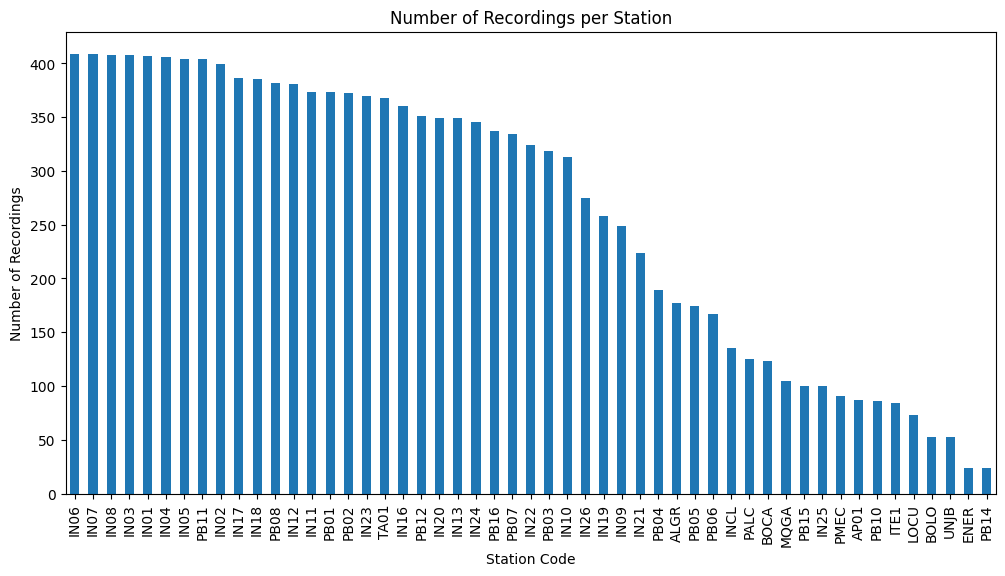

In [30]:
station_counts = iquique_metadata['station_code'].value_counts()
plt.figure(figsize=(12, 6))
station_counts.plot(kind='bar')
plt.title("Number of Recordings per Station")
plt.xlabel("Station Code")
plt.ylabel("Number of Recordings")
plt.show()

#### source_depth_km distribution

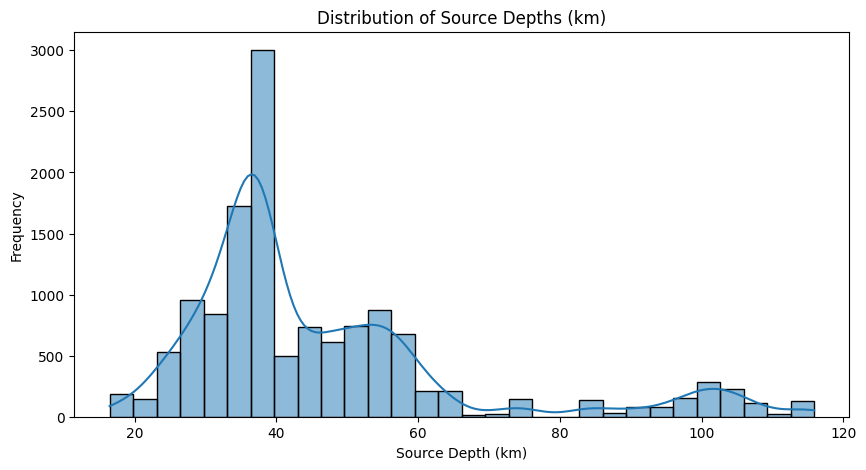

In [33]:
source_depth_km_counts = iquique_metadata['source_depth_km']
plt.figure(figsize=(10, 5))
sns.histplot(source_depth_km_counts, bins=30, kde=True)
plt.title("Distribution of Source Depths (km)")
plt.xlabel("Source Depth (km)")
plt.ylabel("Frequency")
plt.show()

### Sampling rate

In [35]:
sample_rates = iquique_metadata['trace_sampling_rate_hz'].unique()
print("Unique sample rates in the dataset:", sample_rates)

Unique sample rates in the dataset: [100.]


Every datapoint has the same sampling rate of 100Hz
Sampling rate ( trace_sampling_rate_hz ) is the number of waveform samples recorded per second, measured in Hertz (Hz). For example, a sampling rate of 100 Hz means the signal is stored as 100 samples per second, so the time step between consecutive samples is Δt = 1/100 = 0.01 s (10 ms). You can convert a sample index n to time (in seconds) using t = n / fs, and the total duration of a trace with N samples is N / fs

#### Data quality

In [36]:
trace_completeness_mask = iquique_metadata['trace_completeness'] >= 1
complete_traces = iquique_metadata[trace_completeness_mask]
incomplete_traces = iquique_metadata[~trace_completeness_mask]

print("Number of complete traces:", len(complete_traces))
print("Number of incomplete traces:", len(incomplete_traces))

Number of complete traces: 13274
Number of incomplete traces: 126


In [38]:
has_spikes_mask = iquique_metadata['trace_has_spikes'] == True
spiky_traces = iquique_metadata[has_spikes_mask]
non_spiky_traces = iquique_metadata[~has_spikes_mask]

print("Number of traces with spikes:", len(spiky_traces))
print("Number of traces without spikes:", len(non_spiky_traces))

Number of traces with spikes: 13
Number of traces without spikes: 13387


#### P-S sanity check

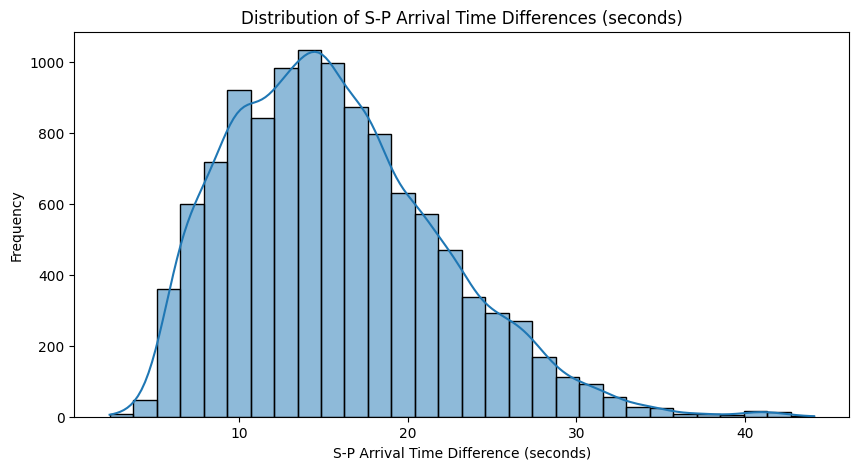

In [42]:
P_S_time_differences = (iquique_metadata['trace_S_arrival_sample'] - iquique_metadata['trace_P_arrival_sample'])/iquique_metadata['trace_sampling_rate_hz']
plt.figure(figsize=(10, 5))
sns.histplot(P_S_time_differences, bins=30, kde=True)
plt.title("Distribution of S-P Arrival Time Differences (seconds)")
plt.xlabel("S-P Arrival Time Difference (seconds)")
plt.ylabel("Frequency")
plt.show()

All S–P time differences are non-negative, meaning S arrivals occur after P arrivals in every trace. This passes a basic sanity check for pick consistency, but it does not guarantee that all picks are accurate or that the signals are noise-free.

# 2. Sampling timne windows

In [ ]:
@dataclass
class WindowSample:
    x_win: np.ndarray                 # (C, win_len)
    meta_win: Dict[str, Any]          # metadata for the window (picks shifted etc.)
    start_idx: int                    # start sample index in the full trace
    end_idx: int                      # end sample index (exclusive)
    fs: float                         # sampling rate (Hz)


def _to_numpy(x: Any) -> np.ndarray:
    """Convert torch/np to np.ndarray without changing values."""
    if isinstance(x, np.ndarray):
        return x
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    raise TypeError(f"Unsupported type: {type(x)}")


def _row_to_dict(row) -> Dict[str, Any]:
    """Pandas Series -> plain dict."""
    return row.to_dict()


def sample_random_window_from_trace(
    waveforms: Any,
    metadata: Dict[str, Any],
    window_size_s: float,
    key: str = "X",
) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Apply SeisBench RandomWindow to a single trace.
    Returns:
      x_win: (C, win_len) numpy
      meta_win: dict (shifted picks etc.)
    """
    x = _to_numpy(waveforms)
    fs = float(metadata["trace_sampling_rate_hz"])
    win_len = int(round(window_size_s * fs))

    if x.shape[1] < win_len:
        raise ValueError(f"Trace too short: N={x.shape[1]} < win_len={win_len}")

    rw = RandomWindow(windowlen=win_len, key=key)

    state = {key: (x.copy(), dict(metadata))}
    rw(state)
    x_win, meta_win = state[key]
    return x_win, meta_win


def find_window_start_idx(
    x_win: Any,
    waveforms_full: Any,
    component: int = 0,
    atol: float = 1e-6,
) -> int:
    """
    Find where x_win occurs inside waveforms_full by matching one component.
    Returns start sample index.
    """
    full = _to_numpy(waveforms_full)
    win = _to_numpy(x_win)

    win_len = win.shape[1]
    N = full.shape[1]
    if N < win_len:
        raise ValueError("Full trace shorter than window.")

    full_1 = full[component]
    win_1 = win[component]

    for s in range(0, N - win_len + 1):
        # np.allclose is fast and robust
        if np.allclose(full_1[s:s + win_len], win_1, atol=atol, rtol=0):
            return s

    raise RuntimeError("Could not locate the window inside the full trace.")


def sample_window(
    dataset: WaveformDataset,
    dataset_index: int,
    window_size_s: float,
) -> WindowSample:
    """
    High-level function: loads trace+metadata from dataset, samples random window,
    and returns window + shifted metadata + where it came from in the full trace.
    """
    row = dataset.metadata.iloc[dataset_index]
    meta = _row_to_dict(row)
    waveforms = dataset.get_waveforms(dataset_index)

    fs = float(meta["trace_sampling_rate_hz"])
    x_win, meta_win = sample_random_window_from_trace(
        waveforms=waveforms,
        metadata=meta,
        window_size_s=window_size_s,
        key="X",
    )

    start_idx = find_window_start_idx(x_win=x_win, waveforms_full=waveforms)
    end_idx = start_idx + x_win.shape[1]

    return WindowSample(
        x_win=x_win,
        meta_win=meta_win,
        start_idx=start_idx,
        end_idx=end_idx,
        fs=fs,
    )


def samples_to_seconds(samples: float, fs: float) -> float:
    return float(samples) / float(fs)


def window_bounds_seconds(sample: WindowSample) -> Tuple[float, float]:
    return samples_to_seconds(sample.start_idx, sample.fs), samples_to_seconds(sample.end_idx, sample.fs)


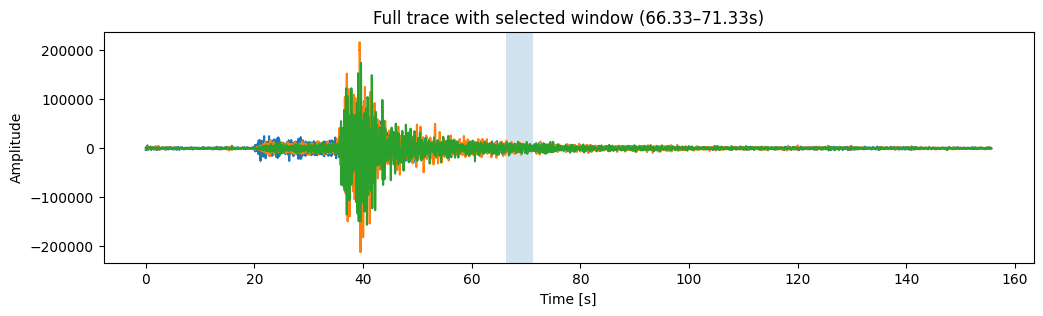

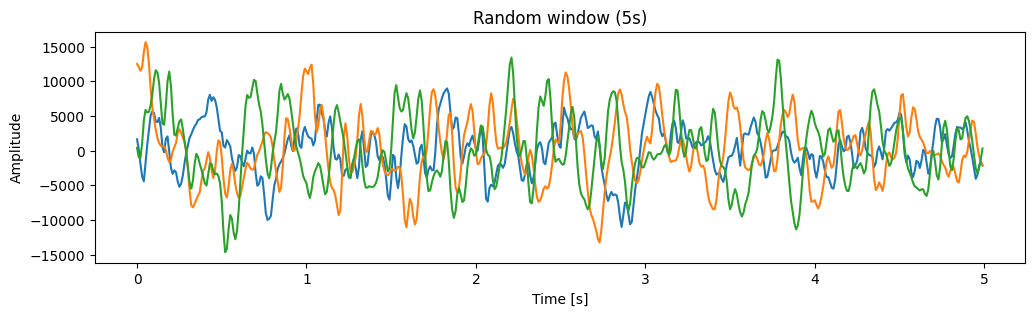

P sample in window: -4633.0
S sample in window: -3069.0


In [ ]:
sample = sample_window(iquique_dataset, dataset_index=0, window_size_s=5.0)

full = _to_numpy(iquique_dataset.get_waveforms(0))
t_full = np.arange(full.shape[1]) / sample.fs

t0, t1 = window_bounds_seconds(sample)

plt.figure(figsize=(12, 3))
plt.plot(t_full, full.T)
plt.axvspan(t0, t1, alpha=0.2)
plt.title(f"Full trace with selected window ({t0:.2f}–{t1:.2f}s)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

t_win = np.arange(sample.x_win.shape[1]) / sample.fs
plt.figure(figsize=(12, 3))
plt.plot(t_win, sample.x_win.T)
plt.title("Random window (5s)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

print("P sample in window:", sample.meta_win.get("trace_P_arrival_sample"))
print("S sample in window:", sample.meta_win.get("trace_S_arrival_sample"))
